In [1]:
import pandas as pd
import numpy as np
import wandb
import re
from collections import defaultdict
import matplotlib.pyplot as plt

from nb_funcs import init_mpl
init_mpl()

In [127]:
from nb_funcs import make_df_from_wandb_runs

api = wandb.Api()
runs = api.runs('tberm-org/trunc-data-ft')


def run_to_row(run):
    if 'too-short' in run.tags or 'too-long' in run.tags:
        return {}
    if run.state == 'running':
        return {}
        
    name_pat = re.compile(r'trunc-data-(\d+)-((r\d)|(nat))')
    match = name_pat.match(run.name)
    if match is None:
        return {}
    nom_size = int(match.groups()[0])
    if nom_size < 100:
        exp_rank = 2
    elif nom_size >= 2000:
        exp_rank = 8
    else:
        exp_rank = 4
        
    actual_rank = run.config['train_config']['lora_r']
    if actual_rank != exp_rank:
        return {}

    if 'average_precision' not in run.summary:
        print('Missing av prec for run', run.name)
        return {}
        
    return {
        'name': run.name,
        'nom_size': nom_size,
        'pos_items': nom_size / 2,
        'actual_size': run.config['train_config']['trunc_dataset'], 
        'rank': actual_rank,
        'num_epochs': run.config['train_config']['num_epochs'],
        'balanced': match.groups()[3] is None,
        'average_precision': run.summary['average_precision'],
        'f1': run.summary['f1'],
        'precision@95': run.summary.get('precision@95'),
    }
    
    
run_dicts = []
for run in runs:
    run_dict = run_to_row(run)
    if run_dict:
        run_dicts.append(run_dict)
        
df = pd.DataFrame(run_dicts)

In [129]:
api = wandb.Api()
# llama 0 shot on val_split, no reminder or truncation
bl_run = api.run('tberm-org/zero-shot-final/vitdpech')
baseline = bl_run.summary.average_precision

baseline_prec95 = bl_run.summary['precision@95']

In [2]:
from sklearn.linear_model import LinearRegression


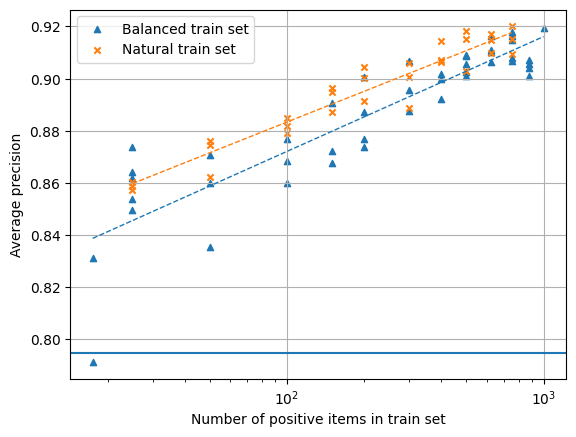

In [92]:
balanced = df[df.balanced]
natural = df[~df.balanced]

fig, ax = plt.subplots()
ax.scatter(balanced.pos_items, balanced.average_precision, label='Balanced train set', marker='^', s=20)
ax.scatter(natural.pos_items, natural.average_precision, label='Natural train set', marker='x', s=20)

plt.xscale('log')

lr = LinearRegression()
log_x = np.log10(balanced.pos_items.to_numpy().reshape(-1,1))
lr.fit(log_x, balanced[['average_precision']])
range = np.array([[log_x.min()], [log_x.max()]])
balanced_preds = lr.predict(range)precision
ax.plot(10 ** range, balanced_preds, '--', lw=1)

lr = LinearRegression()
log_x = np.log10(natural.pos_items.to_numpy().reshape(-1,1))
lr.fit(log_x, natural[['average_precision']])
range = np.array([[log_x.min()], [log_x.max()]])
natural_preds = lr.predict(range)
ax.plot(10 ** range, natural_preds, '--', lw=1)

ax.axhline(y=baseline)

ax.legend()
ax.set_xlabel('Number of positive items in train set')
ax.set_ylabel('Average precision')

plt.grid(True)

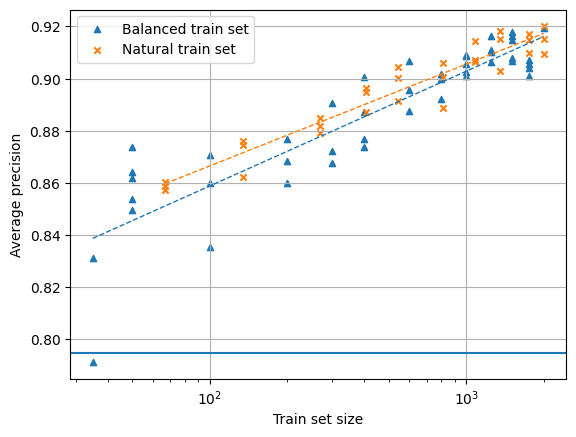

In [93]:
balanced = df[df.balanced]
natural = df[~df.balanced]

fig, ax = plt.subplots()
ax.scatter(balanced.actual_size, balanced.average_precision, label='Balanced train set', marker='^', s=20)
ax.scatter(natural.actual_size, natural.average_precision, label='Natural train set', marker='x', s=20)

plt.xscale('log')

lr = LinearRegression()
log_x = np.log10(balanced.actual_size.to_numpy().reshape(-1,1))
lr.fit(log_x, balanced[['average_precision']])
range = np.array([[log_x.min()], [log_x.max()]])
balanced_preds = lr.predict(range)
ax.plot(10 ** range, balanced_preds, '--', lw=1)

lr = LinearRegression()
log_x = np.log10(natural.actual_size.to_numpy().reshape(-1,1))
lr.fit(log_x, natural[['average_precision']])
range = np.array([[log_x.min()], [log_x.max()]])
natural_preds = lr.predict(range)
ax.plot(10 ** range, natural_preds, '--', lw=1)

ax.axhline(y=baseline)

ax.legend()
ax.set_xlabel('Train set size')
ax.set_ylabel('Average precision')

plt.grid(True)

fig.savefig('../../report/latex/figures/trunc_data.pdf')

In [136]:
def make_graph(df, metric, log=True, with_svm=True, with_fit=True):
    balanced = df[df.balanced]
    natural = df[~df.balanced]
    
    fig, ax = plt.subplots()
    ax.scatter(balanced.actual_size, balanced[metric], label='LLM - balanced train set', marker='^', s=20, color='C0')
    if metric != 'precision@95':
        ax.scatter(natural.actual_size, natural[metric], label='LLM - natural train set', marker='x', s=20, color='C1')
    
    if log:
        plt.xscale('log')

    if with_fit:
        lr = LinearRegression()
        x = balanced.actual_size.to_numpy().reshape(-1,1)
        if log:
            x = np.log10(x)
        lr.fit(x, balanced[[metric]])
        range = np.array([[x.min()], [x.max()]])
        balanced_preds = lr.predict(range)
    
        line_x = 10 ** range if log else range
        ax.plot(line_x, balanced_preds, '--', lw=1, color='C0')

        if metric != 'precision@95':
            lr = LinearRegression()
            x = natural.actual_size.to_numpy().reshape(-1,1)
            if log:
                x = np.log10(x)
            lr.fit(x, natural[[metric]])
            range = np.array([[x.min()], [x.max()]])
            natural_preds = lr.predict(range)
        
            line_x = 10 ** range if log else range
            ax.plot(line_x, natural_preds, '--', lw=1, color='C1')

    if metric == 'average_precision':
        ax.axhline(y=baseline, label='LLM - zero shot', ls='--')
    elif metric == 'precision@95':
        ax.axhline(y=baseline_prec95, label='LLM - zero shot', ls='--')

    if with_svm:
        if metric == 'average_precision':
            svm_sizes = np.genfromtxt('../../systematic_reviews/scatter_plot_sizes.txt')
            svm_scores = np.genfromtxt('../../systematic_reviews/scatter_plot_av_p.txt')
        elif metric == 'precision@95':
            svm_sizes = np.genfromtxt('../../systematic_reviews/scatter_plot_sizes_prec95.txt')
            svm_scores = np.genfromtxt('../../systematic_reviews/scatter_plot_prec95.txt')
        else:
            raise Exception(metric)
            
        ax.scatter(svm_sizes, svm_scores, label='SVM - natural train set', s=10, color='C2')

        if with_fit:
            lr = LinearRegression()
            x = svm_sizes.reshape(-1,1)
            if log:
                x = np.log10(x)
            lr.fit(x, svm_scores.reshape(-1,1))
            range = np.array([[x.min()], [x.max()]])
            lr_preds = lr.predict(range)
            line_x = 10 ** range if log else range
            ax.plot(line_x, lr_preds, '--', lw=1, color='C2')
    
    ax.legend()
    ax.set_xlabel('Train set size')
    ax.set_ylabel(metric)
    
    plt.grid(True)
    
    return fig, ax

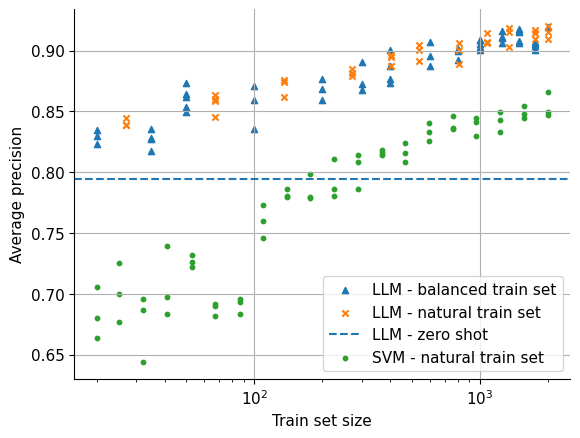

In [143]:
fig, ax = make_graph(df, 'average_precision', log=True, with_fit=False)
plt.ylabel('Average precision')
fig.savefig('../../report/latex/figures/trunc_data.pdf')

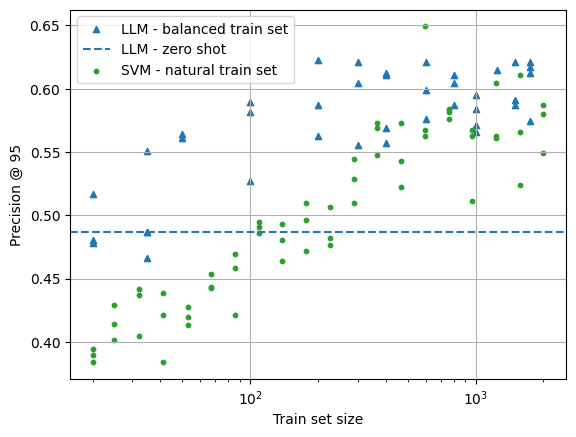

In [137]:
fig, ax = make_graph(df, 'precision@95', log=True, with_fit=False)
plt.ylabel('Precision @ 95')
fig.savefig('../../report/latex/figures/trunc_data_prec95.pdf')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Train set size', ylabel='f1'>)

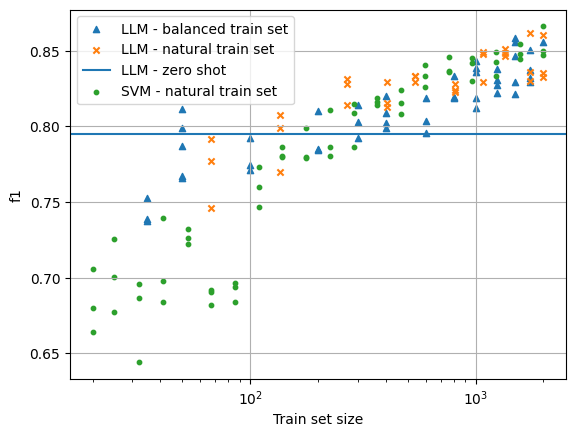

In [106]:
make_graph(df, 'f1', log=True, with_fit=False)

In [6]:
api = wandb.Api()
runs = api.runs('tberm-org/one-offs')
run = [run for run in runs if run.name == 'full-eval'][0]
baseline_scores = run.summary

In [3]:
def plot_run_group(runs, metric, fig=None, ax=None, line_kwargs=None):
    if fig is None:
        fig, ax = plt.subplots()

    lows, means, highs, steps = [], [], [], []
    run_values = [run.history(keys=[f'eval/{metric}'], pandas=False) for run in runs]
    for step_dicts in zip(*run_values):
        step_in_each_run = [dic['_step'] for dic in step_dicts]
        assert len(set(step_in_each_run)) == 1, 'Steps should be aligned between runs'
        steps.append(step_in_each_run[0])
        values = np.array([dic[f'eval/{metric}'] for dic in step_dicts])
        lows.append(values.min())
        means.append(values.mean())
        highs.append(values.max())

    line_kwargs = line_kwargs or {}
    ax.plot(steps, means, **line_kwargs)
    ax.fill_between(steps, lows, highs, alpha=0.3)
    ax.set_ylabel(metric)
    ax.set_xlabel('step')
    return fig, ax

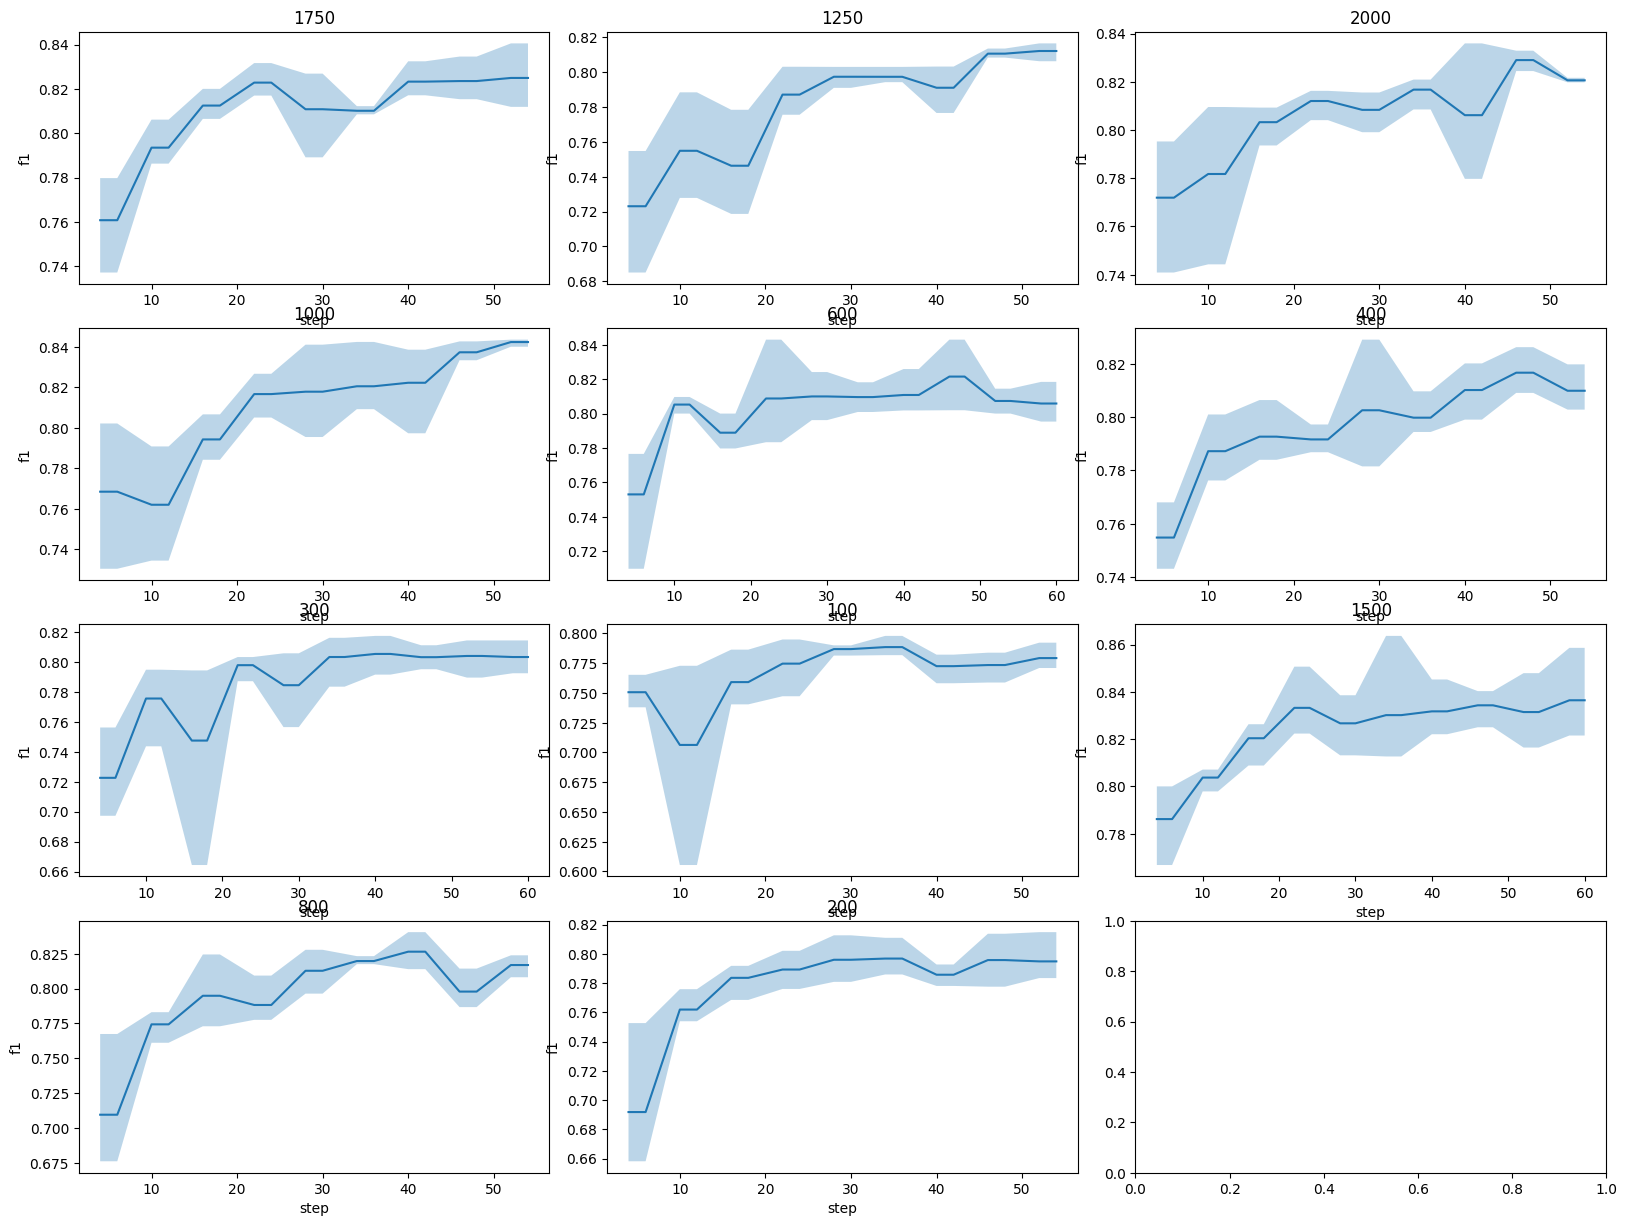

In [58]:
fig, ax_rows = plt.subplots(4,3, figsize=(16,12))
fig.tight_layout()
axes = [ax for row in ax_rows for ax in row]
i = 0
for group_name, group_runs in run_groups.items():
    ds_size = group_name.split('-')[2]
    plot_run_group(group_runs, 'f1', fig, axes[i], {'label': ds_size})
    axes[i].set_title(ds_size)
    i += 1

    